<a href="https://colab.research.google.com/github/mehdi-abbasi/Deep_Facial_Expression_Recognition/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install hub
! pip install kaggle
! mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download deadskull7/fer2013
! unzip /content/fer2013.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/fer2013.zip
replace fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fer2013.csv             


In [82]:
import hub
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import confusion_matrix

In [49]:
# ds = hub.load('hub://activeloop/fer2013-train')
# ds_test = hub.load('hub://activeloop/fer2013-test')
# ds.visualize()

data = pd.read_csv('/content/fer2013.csv')
print(data.shape)
data.head

(35887, 3)


<bound method NDFrame.head of        emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 colum

In [52]:
# test = data['pixels']
# print(len(test))

# print(len(my_arr))
# print(list(data['Usage']).count('PublicTest'))y
# print(list(data['Usage']).count('PrivateTest'))
# print(list(data['Usage']).count('Training'))

training = data[data['Usage'] == 'Training']
public_test = data[data['Usage'] == 'PublicTest']
private_test = data[data['Usage'] == 'PrivateTest']

x_train = training['pixels'].astype(str).str.split(" ").tolist()
x_train = np.uint8(x_train)
x_train = x_train.reshape((len(training), 48, 48))
y_train = to_categorical(training['emotion'], num_classes=7)


x_val = public_test['pixels'].astype(str).str.split(" ").tolist()
x_val = np.uint8(x_val)
x_val = x_val.reshape((len(public_test), 48, 48))
y_val = to_categorical(public_test['emotion'], num_classes=7)


x_test = private_test['pixels'].astype(str).str.split(" ").tolist()
x_test = np.uint8(x_test)
x_test = x_test.reshape((len(private_test), 48, 48))
y_test = to_categorical(private_test['emotion'], num_classes=7)

28709
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
6


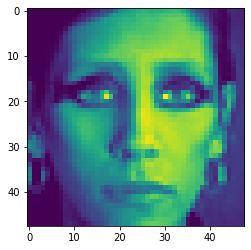

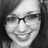

In [51]:
print(len(y_train))
print(y_train)
i = 4
print(training['emotion'][i])
plt.imshow(x_train[i])
plt.show()

from google.colab.patches import cv2_imshow
cv2_imshow(x_val[i])

In [4]:
# CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
# fig = px.bar(x = CLASS_LABELS,
#              y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
#              color = np.unique(data['emotion']) ,
#              color_continuous_scale="Emrld") 
# fig.update_xaxes(title="Emotions")
# fig.update_yaxes(title = "Number of Images")
# fig.update_layout(showlegend = True,
#     title = {
#         'text': 'Train Data Distribution ',
#         'y':0.95,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'})
# fig.show()

In [5]:
# # shuffle dataset
# data = data.sample(frac=1)

In [6]:
# labels = to_categorical(data[['emotion']], num_classes=7)
# train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
# train_pixels = np.uint8(train_pixels)

In [51]:
# labels.shape
# # train_pixels.shape

(35887, 7)

In [7]:
# pixels = train_pixels.reshape((35887*2304,1))
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# pixels = scaler.fit_transform(pixels)

In [8]:
# pixels = train_pixels.reshape((35887, 48, 48,1))

In [18]:
# X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
# print(X_train.shape)
# print(type(X_train))
# print(X_test.shape)
# print(X_val.shape)

(29068, 48, 48, 1)
<class 'numpy.ndarray'>
(3589, 48, 48, 1)
(3230, 48, 48, 1)


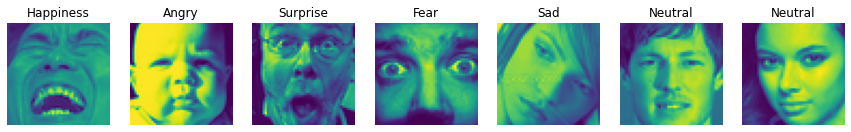

In [10]:
# plt.figure(figsize=(15,23))
# label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
# i = 1
# for i in range (7):
#     img = np.squeeze(X_train[i])
#     plt.subplot(1,7,i+1)
#     plt.imshow(img)
#     index = np.argmax(y_train[i])
#     plt.title(label_dict[index])
#     plt.axis('off')
#     i += 1
# plt.show()

In [11]:
# datagen = ImageDataGenerator(  width_shift_range = 0.1,
#                                height_shift_range = 0.1,
#                                horizontal_flip = True,
#                                zoom_range = 0.2)
# valgen = ImageDataGenerator(   width_shift_range = 0.1,
#                                height_shift_range = 0.1,
#                                horizontal_flip = True,
#                                zoom_range = 0.2) 

# datagen.fit(X_train)
# valgen.fit(X_val)

# train_generator = datagen.flow(X_train, y_train, batch_size=64)
# val_generator = datagen.flow(X_val, y_val, batch_size=64)

In [87]:
model = keras.models.Sequential([keras.layers.Conv2D(64,4,input_shape=(48,48,1),activation='relu',padding='same'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Conv2D(64,4,activation='relu',padding='same'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPooling2D(4,2),
                                 keras.layers.Conv2D(64,4,activation='relu',padding='same'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Conv2D(64,4,activation='relu',padding='same'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPooling2D(4,2),
                                 keras.layers.Dropout(0.1),
                                 keras.layers.Conv2D(128,4,activation='relu',padding='same'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Conv2D(64,4,activation='relu',padding='same'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPooling2D(4,2),
                                 keras.layers.Dropout(0.1),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(1024,activation='relu'),
                                 keras.layers.Dropout(0.1),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(1024,activation='relu'),
                                 keras.layers.Dropout(0.1),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(7,activation='softmax'),
                                ])

In [88]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=Adam(learning_rate=0.0001))
# model.summary()

In [89]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [90]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=10,
                    batch_size=16,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=(x_val,y_val))

Epoch 1/10
1791/1795 [============================>.] - ETA: 0s - loss: 2.0019 - accuracy: 0.2933
Epoch 1: val_accuracy improved from -inf to 0.38980, saving model to best_model.h5
1795/1795 [==============================] - 27s 14ms/step - loss: 2.0017 - accuracy: 0.2935 - val_loss: 1.6156 - val_accuracy: 0.3898
Epoch 2/10
1793/1795 [============================>.] - ETA: 0s - loss: 1.5985 - accuracy: 0.4050
Epoch 2: val_accuracy improved from 0.38980 to 0.47841, saving model to best_model.h5
1795/1795 [==============================] - 25s 14ms/step - loss: 1.5984 - accuracy: 0.4050 - val_loss: 1.3797 - val_accuracy: 0.4784
Epoch 3/10
1792/1795 [============================>.] - ETA: 0s - loss: 1.4224 - accuracy: 0.4650
Epoch 3: val_accuracy improved from 0.47841 to 0.52159, saving model to best_model.h5
1795/1795 [==============================] - 25s 14ms/step - loss: 1.4224 - accuracy: 0.4650 - val_loss: 1.3040 - val_accuracy: 0.5216
Epoch 4/10
1792/1795 [========================

In [91]:
# model.save('cnn_model_30epoch_Adam.h5')
model = keras.models.load_model('best_model.h5')

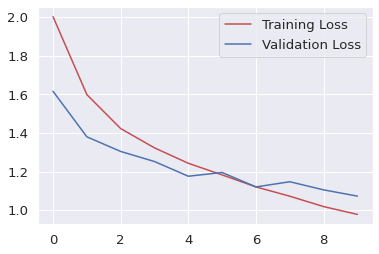

In [92]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

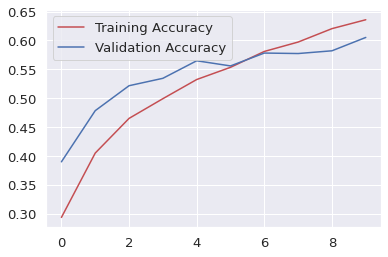

In [93]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [94]:
loss = model.evaluate(x_test,y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 8ms/step - loss: 1.0314 - accuracy: 0.6197
Test Acc: 0.6196712255477905


In [95]:
preds = model.predict(x_test)
y_pred = np.argmax(preds , axis = 1 )

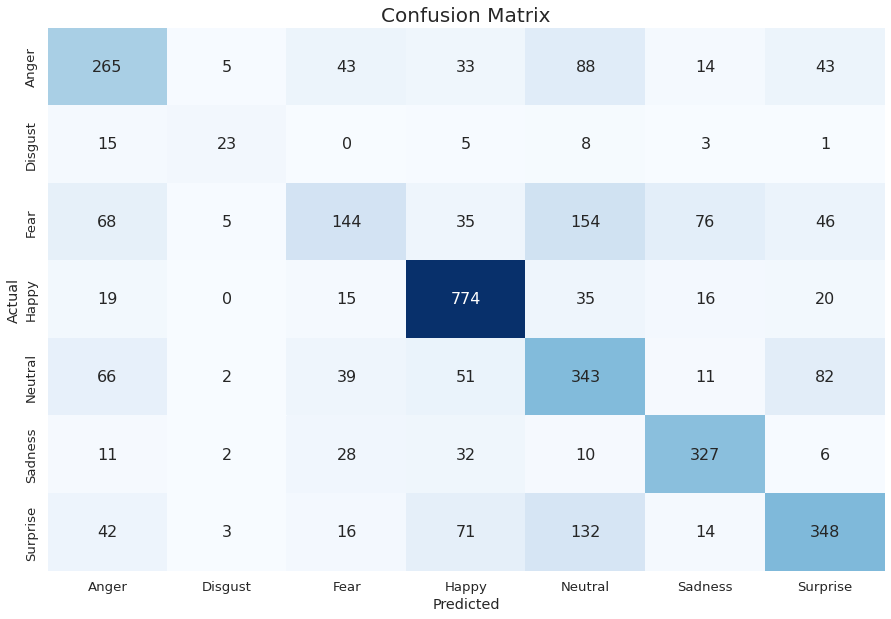

In [96]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [97]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.545     0.540     0.542       491
           1      0.575     0.418     0.484        55
           2      0.505     0.273     0.354       528
           3      0.773     0.881     0.823       879
           4      0.445     0.577     0.503       594
           5      0.709     0.786     0.746       416
           6      0.637     0.556     0.594       626

    accuracy                          0.620      3589
   macro avg      0.599     0.576     0.578      3589
weighted avg      0.614     0.620     0.609      3589

